# Setup

In [82]:
!pip install ipympl
from google.colab import output
output.enable_custom_widget_manager()

!pip install ultralytics
!pip install supervision

!git clone https://github.com/ifzhang/ByteTrack.git
%cd /content/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop


fatal: destination path 'ByteTrack' already exists and is not an empty directory.
/content/ByteTrack
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Could not find a version that satisfies the requirement onnxruntime==1.8.0 (from versions: 1.12.0, 1.12.1, 1.13.1, 1.14.0, 1.14.1, 1.15.0, 1.15.1)
ERROR: No matching distribution found for onnxruntime==1.8.0
/usr/local/lib/python3.10/dist-packages/setuptools/command/develop.py:40: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for deta

In [83]:
%cd /content
import sys
sys.path.append(f"ByteTrack")

/content


In [84]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")
model.fuse()

YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs


In [85]:
!git clone https://github.com/KaiyangZhou/deep-person-reid.git
%cd deep-person-reid/
!pip install -r requirements.txt

fatal: destination path 'deep-person-reid' already exists and is not an empty directory.
/content/deep-person-reid


In [86]:
!gdown 1LaG1EJpHrxdAxKnSCJ_i0u-nbxSAeiFY
%cd /content
import sys
sys.path.append(f"deep-person-reid")

Downloading...
From: https://drive.google.com/uc?id=1LaG1EJpHrxdAxKnSCJ_i0u-nbxSAeiFY
To: /content/deep-person-reid/osnet_x1_0_imagenet.pth
100% 10.9M/10.9M [00:00<00:00, 67.7MB/s]
/content


# Declare utility classes and functions

1.   List item
2.   List item



In [87]:
from typing import List

import numpy as np
from supervision import Detections
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack



# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [59]:
from dataclasses import dataclass
from onemetric.cv.utils.iou import box_iou_batch
from yolox.tracker.byte_tracker import BYTETracker, STrack


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 100
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

# Preprocess video

In [60]:
from supervision import (
    ColorPalette,
    Color,
    BoxAnnotator,
    Point,
    LineZone,
    LineZoneAnnotator,
    get_video_frames_generator,
    VideoInfo,
    VideoSink
)

In [61]:
def get_video_shape(video_path):
    generator = get_video_frames_generator(video_path)
    iterator = iter(generator)
    frame = next(iterator)
    return frame.shape

In [62]:
class_names_dict = model.model.names
classes = [0, 2, 5, 7]


scaled_video_path = "resized.mp4"
target_video_path = "result.mp4"

thickness = 2
text_thickness = 2
text_scale = 1

In [63]:
# scale_ratio = 0.7
# width, height = get_video_shape(source_video_path)[:2]
# scaled_size = f"scale={int(height*scale_ratio/2) * 2}:{int(width*scale_ratio/2) * 2}"

# !ffmpeg -i {source_video_path} -crf 18 -preset veryfast \
#         -hide_banner -loglevel error \
#         -vf {scaled_size} -vcodec libx264 {scaled_video_path} -y

# get_video_shape(scaled_video_path)

# Draw lines on video and plot

In [64]:
# !gdown 1zd5Icrh7bDz2XkRh1a-blTz70HyOF6Ft
# !gdown 1RGYm13bh38QJ1jDbaQlBmVR0PpzXIYgs
# !gdown 1h3LMJFZ380ZqP7SuHzWUyOHZZbgqaUyF
# !gdown 12E6h1R5WY8J3BomkSO5kUU8sUSxjkYj_

# Download videos with covered person
# !gdown 1JuvkI_Bf-N7ki0lodNh8csDzLabuigyK -O cam1.mp4
# !gdown 116V1O0YFqxWA1afisrmkq5I6gJ8jp4eq -O cam2.mp4

# download videos without covered person
!gdown 1dsAFDkAfIF005olWCyZ8De_W5MbgB6aF -O cam1.mp4
!gdown 1QobgtQfTQwDKNS5joLA8IrFactw2fWxn -O cam2.mp4

Downloading...
From: https://drive.google.com/uc?id=1dsAFDkAfIF005olWCyZ8De_W5MbgB6aF
To: /content/cam1.mp4
100% 35.3M/35.3M [00:00<00:00, 116MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1QobgtQfTQwDKNS5joLA8IrFactw2fWxn
To: /content/cam2.mp4
100% 40.9M/40.9M [00:00<00:00, 76.4MB/s]


## First Camera

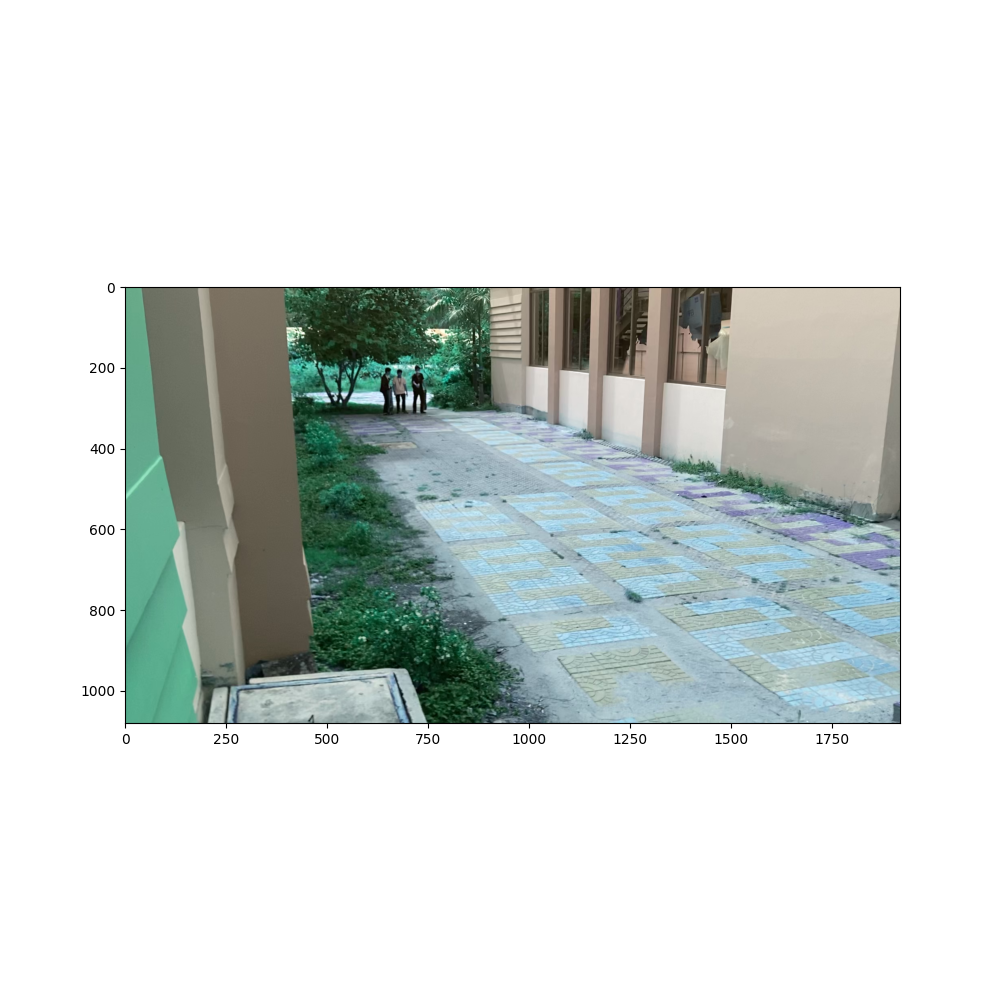

In [65]:
%matplotlib ipympl

import matplotlib
import matplotlib.pyplot as plt


generator = get_video_frames_generator("cam1.mp4")

iterator = iter(generator)
frame = next(iterator)


fig = plt.figure(figsize=(10, 10))
plt.imshow(frame)

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(f"Point({round(ix)}, {round(iy)})")

cid = fig.canvas.mpl_connect('button_press_event', on_click)

In [66]:
# Covered
# line_start = Point(336, 458)
# line_end = Point(901, 408)

# Uncorvered
line_start = Point(433, 388)
line_end = Point(1008, 304)

In [67]:
%%capture
%matplotlib inline

# Change mode and clear output
plt.figure(figsize=(8, 8))
plt.show()

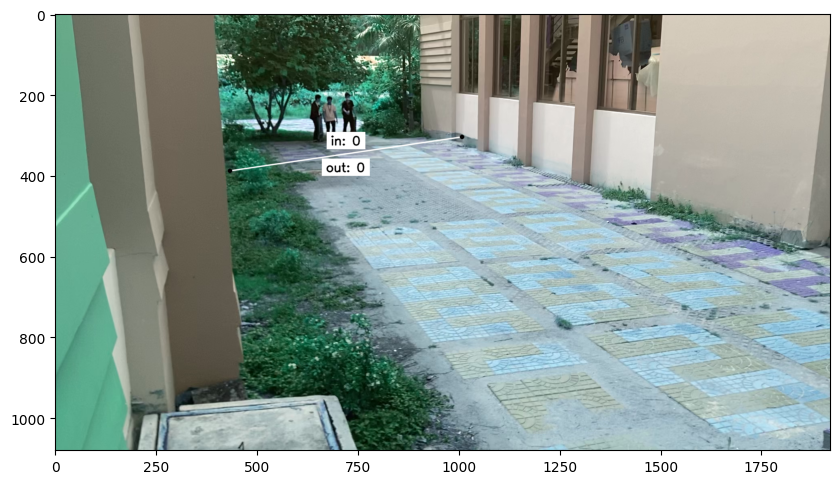

(1080, 1920, 3)

In [68]:

line_counter = LineZone(start=line_start, end=line_end)
line_annotator = LineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)
line_annotator.annotate(frame=frame, line_counter=line_counter)

plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()
frame.shape

## Second Camera

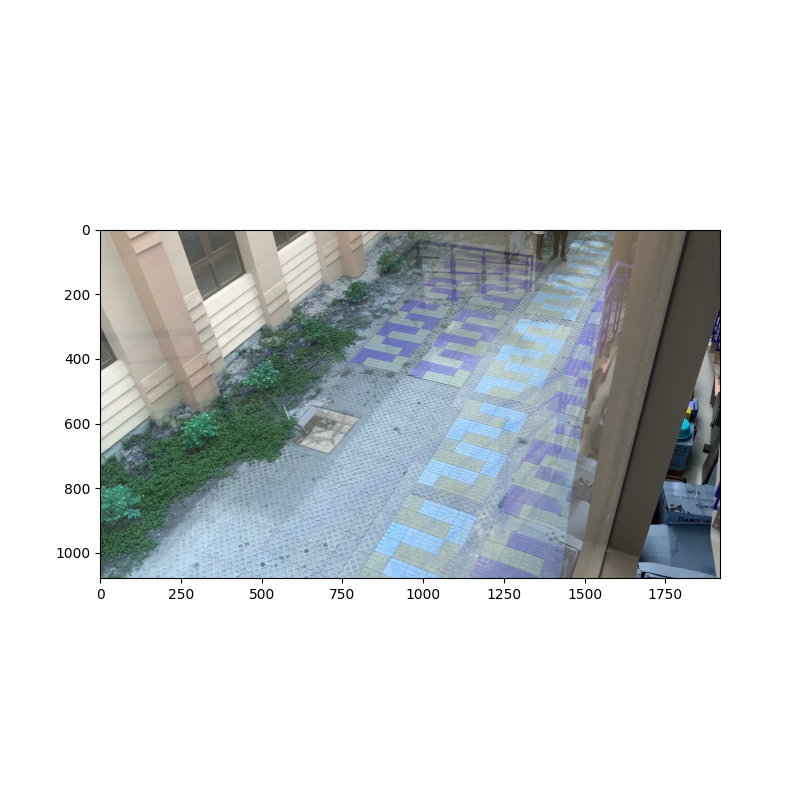

In [69]:
%matplotlib ipympl

import matplotlib
import matplotlib.pyplot as plt


generator = get_video_frames_generator("cam2.mp4")

iterator = iter(generator)
frame = next(iterator)


fig = plt.figure(figsize=(8, 8))
plt.imshow(frame)

def on_click(event):
    ix, iy = event.xdata, event.ydata
    print(f"Point({round(ix)}, {round(iy)})")

cid = fig.canvas.mpl_connect('button_press_event', on_click)

In [70]:
# Covered
# line_start_2 = Point(405, 577)
# line_end_2 = Point(1498, 815)

# Uncovered
line_start_2 = Point(414, 456)
line_end_2 = Point(1545, 732)

In [71]:
%%capture
%matplotlib inline

# Change mode and clear output
plt.figure(figsize=(10, 10))
plt.show()

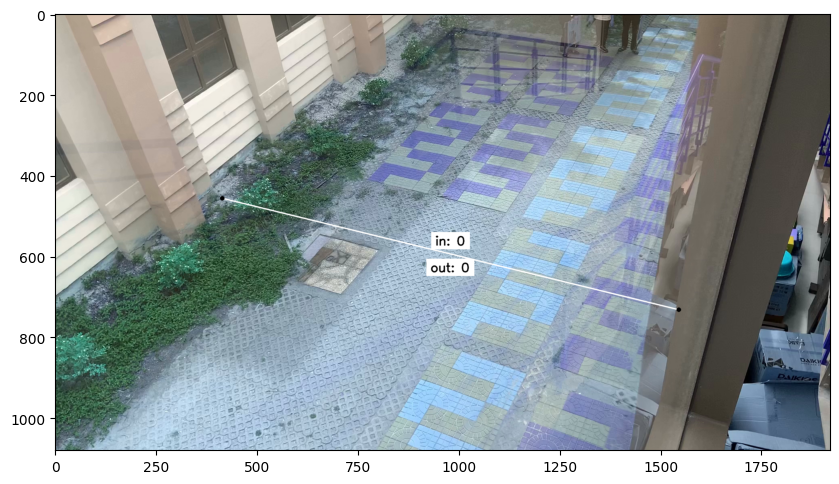

(1080, 1920, 3)

In [72]:

line_counter = LineZone(start=line_start_2, end=line_end_2)
line_annotator = LineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)
line_annotator.annotate(frame=frame, line_counter=line_counter)

plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()
frame.shape

# Get tracking video

In [73]:
from torchreid.utils import FeatureExtractor

extractor = FeatureExtractor(
    model_name="osnet_x1_0",
    model_path="/content/osnet_x1_0_imagenet.pth",
    device="cuda"
)

/content/deep-person-reid/torchreid/utils/tools.py:43: UserWarning: No file found at "/content/osnet_x1_0_imagenet.pth"
  warnings.warn('No file found at "{}"'.format(fpath))


Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352


In [74]:
import torch
from torch.nn import CosineSimilarity
from torch.nn.functional import normalize

def find_highest_value_index(tensor_array, threshold):
    indices = (tensor_array > threshold).nonzero()
    if indices.numel() > 0:
        indices_above_threshold = indices[:, 0]
        index_highest_value = torch.argmax(tensor_array[indices_above_threshold])
        final_index = indices_above_threshold[index_highest_value].item()
        return final_index
    else:
        return -1


def get_sorted_indices_above_threshold(tensor_array, threshold):
    removed_indices = [index for index, value in enumerate(tensor_array.tolist())
                                if value < threshold]
    sorted_indices = torch.argsort(tensor_array, descending=True).tolist()
    return [i for i in sorted_indices if i not in removed_indices]



def get_people_from_detections(detections, frame):
    people = list()
    for box in detections.xyxy:
        left, top, right, bottom = [int(value) for value in box]
        people.append(frame[top:bottom, left:right])
    return people

def frame2detections(model, frame, byte_tracker):
    results = model(frame, verbose=False)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int)
    )

    detections = detections[np.isin(detections.class_id, classes)]

    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
    detections.tracker_id = np.array(tracker_id)

    mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
    detections = detections[mask]

    return detections

In [75]:
from typing import Dict, Optional

import cv2
import numpy as np

from supervision.detection.core import Detections
from supervision.draw.color import Color
from supervision.geometry.core import Point, Rect, Vector


class LineZoneManager:

    def __init__(self, line_zones):
        self.line_zones = line_zones
        self.count = 0

    def check_tracker_from_all_lines(self, id):
        for line in self.line_zones:
            if id in line.tracker_state.keys() and line.tracker_state[id]:
                return False
        return True

    def update(self):
        for line in self.line_zones:
            if len(line.updated_trackers) > 0:
                for id in line.updated_trackers:
                    if self.check_tracker_from_all_lines(id):
                        self.count += 1
                line.updated_trackers = list()

            line.out_count = self.count



class MyLineZone:
    """
    Count the number of objects that cross a line.
    """

    def __init__(self, start: Point, end: Point):
        """
        Initialize a LineCounter object.

        Attributes:
            start (Point): The starting point of the line.
            end (Point): The ending point of the line.

        """
        self.vector = Vector(start=start, end=end)
        self.tracker_state: Dict[str, bool] = {}
        self.in_count: int = 0
        self.out_count: int = 0
        self.updated_trackers = list()

    def trigger(self, detections: Detections):
        """
        Update the in_count and out_count for the detections that cross the line.

        Attributes:
            detections (Detections): The detections for which to update the counts.

        """
        for xyxy, _, confidence, class_id, tracker_id in detections:
            # handle detections with no tracker_id
            if tracker_id is None:
                continue

            # we check if all four anchors of bbox are on the same side of vector
            x1, y1, x2, y2 = xyxy
            anchors = [
                Point(x=x1, y=y1),
                Point(x=x1, y=y2),
                Point(x=x2, y=y1),
                Point(x=x2, y=y2),
            ]
            triggers = [self.vector.is_in(point=anchor) for anchor in anchors]

            # detection is partially in and partially out
            if len(set(triggers)) == 2:
                continue

            tracker_state = triggers[0]
            # handle new detection
            if tracker_id not in self.tracker_state:
                self.tracker_state[tracker_id] = tracker_state
                continue

            # handle detection on the same side of the line
            if self.tracker_state.get(tracker_id) == tracker_state:
                continue

            self.tracker_state[tracker_id] = tracker_state
            if tracker_state == False:
                self.updated_trackers.append(tracker_id)


class MyLineZoneAnnotator:
    def __init__(
        self,
        thickness: float = 2,
        color: Color = Color.white(),
        text_thickness: float = 2,
        text_color: Color = Color.black(),
        text_scale: float = 0.5,
        text_offset: float = 1.5,
        text_padding: int = 10,
        custom_in_text: Optional[str] = None,
        custom_out_text: Optional[str] = None,
    ):
        """
        Initialize the LineCounterAnnotator object with default values.

        Attributes:
            thickness (float): The thickness of the line that will be drawn.
            color (Color): The color of the line that will be drawn.
            text_thickness (float): The thickness of the text that will be drawn.
            text_color (Color): The color of the text that will be drawn.
            text_scale (float): The scale of the text that will be drawn.
            text_offset (float): The offset of the text that will be drawn.
            text_padding (int): The padding of the text that will be drawn.

        """
        self.thickness: float = thickness
        self.color: Color = color
        self.text_thickness: float = text_thickness
        self.text_color: Color = text_color
        self.text_scale: float = text_scale
        self.text_offset: float = text_offset
        self.text_padding: int = text_padding
        self.custom_in_text: str = custom_in_text
        self.custom_out_text: str = custom_out_text

    def annotate(self, frame: np.ndarray, line_counter: LineZone) -> np.ndarray:
        """
        Draws the line on the frame using the line_counter provided.

        Attributes:
            frame (np.ndarray): The image on which the line will be drawn.
            line_counter (LineCounter): The line counter
                that will be used to draw the line.

        Returns:
            np.ndarray: The image with the line drawn on it.

        """
        cv2.line(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            line_counter.vector.end.as_xy_int_tuple(),
            self.color.as_bgr(),
            self.thickness,
            lineType=cv2.LINE_AA,
            shift=0,
        )
        cv2.circle(
            frame,
            line_counter.vector.start.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )
        cv2.circle(
            frame,
            line_counter.vector.end.as_xy_int_tuple(),
            radius=5,
            color=self.text_color.as_bgr(),
            thickness=-1,
            lineType=cv2.LINE_AA,
        )


        out_text = (
            f"{self.custom_out_text}: {line_counter.out_count}"
            if self.custom_out_text is not None
            else f"out: {line_counter.out_count}"
        )


        (out_text_width, out_text_height), _ = cv2.getTextSize(
            out_text, cv2.FONT_HERSHEY_SIMPLEX, self.text_scale, self.text_thickness
        )


        out_text_x = int(
            (line_counter.vector.end.x + line_counter.vector.start.x - out_text_width)
            / 2
        )
        out_text_y = int(
            (line_counter.vector.end.y + line_counter.vector.start.y + out_text_height)
            / 2
            + self.text_offset * out_text_height
        )

        out_text_background_rect = Rect(
            x=out_text_x,
            y=out_text_y - out_text_height,
            width=out_text_width,
            height=out_text_height,
        ).pad(padding=self.text_padding)

        cv2.rectangle(
            frame,
            out_text_background_rect.top_left.as_xy_int_tuple(),
            out_text_background_rect.bottom_right.as_xy_int_tuple(),
            self.color.as_bgr(),
            -1,
        )

        cv2.putText(
            frame,
            out_text,
            (out_text_x, out_text_y),
            cv2.FONT_HERSHEY_SIMPLEX,
            self.text_scale,
            self.text_color.as_bgr(),
            self.text_thickness,
            cv2.LINE_AA,
        )
        return frame

In [76]:
import cv2
import numpy as np
from tqdm.notebook import tqdm
import time

box_annotator = BoxAnnotator(color=ColorPalette.default(),
                             thickness=thickness,
                             text_thickness=text_thickness,
                             text_scale=text_scale)
line_annotator = MyLineZoneAnnotator(thickness=thickness,
                                   text_thickness=text_thickness,
                                   text_scale=text_scale)

line_counter = MyLineZone(start=line_start, end=line_end)
line_counter_2 = MyLineZone(start=line_start_2, end=line_end_2)

line_manager = LineZoneManager([line_counter, line_counter_2])


byte_tracker = BYTETracker(BYTETrackerArgs())
byte_tracker_2 = BYTETracker(BYTETrackerArgs())

video_info = VideoInfo.from_video_path("/content/cam1.mp4")
video_info_2 = VideoInfo.from_video_path("/content/cam2.mp4")

generator = get_video_frames_generator("/content/cam1.mp4")
generator_2 = get_video_frames_generator("/content/cam2.mp4")

cos = CosineSimilarity(dim=1, eps=1e-6)

track_id_set = set()
track_id_set_2 = set()
mapping_dict = dict()

video_info.width = video_info.width * 2

with VideoSink("tracking_cam.mp4", video_info) as sink:
#     with VideoSink("tracking_cam2.mp4", video_info_2) as sink_2:
    for frame, frame_2 in tqdm(zip(generator, generator_2), total=video_info.total_frames):
        # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        detections = frame2detections(model, frame, byte_tracker)
        tracker_id = detections.tracker_id

        # frame_2 = cv2.cvtColor(frame_2, cv2.COLOR_BGR2RGB)
        detections_2 = frame2detections(model, frame_2, byte_tracker_2)
        tracker_id_2 = detections_2.tracker_id
        # if (track_id_set != set(tracker_id) and
        #     track_id_set_2 != set(tracker_id_2)):
        #     track_id_set = set(tracker_id)
        #     track_id_set_2 = set(tracker_id_2)
        for id in tracker_id_2:
            if id not in mapping_dict.keys():
                mapping_dict[id] = id

        people =  get_people_from_detections(detections,frame)
        people_2 = get_people_from_detections(detections_2, frame_2)

        if len(people) * len(people_2) != 0:
            features = extractor(people)
            features_2 = extractor(people_2)

            for i in range(len(features_2)):
                cosim = cos(features_2[i].unsqueeze(0), features)
                matched_indices = get_sorted_indices_above_threshold(cosim, 0.6)

                if matched_indices is not None:
                    for matched_id in matched_indices:
                        if tracker_id[matched_id] not in mapping_dict.values():
                            double_check_cosim = cos(features[matched_id].unsqueeze(0), features_2)
                            double_check_index = find_highest_value_index(double_check_cosim, 0.7)
                            if i == double_check_index:
                                mapping_dict[tracker_id_2[i]] = tracker_id[matched_id]
                                break

            detections_2.tracker_id = np.array([mapping_dict[id] for id in tracker_id_2])

        # labels = [
        #     f"#{tracker_id}-{class_names_dict[class_id]}"
        #     for __, __, confidence, class_id, tracker_id
        #     in detections
        # ]

        labels = [
            f"#{tracker_id}"
            for __, __, confidence, class_id, tracker_id
            in detections
        ]
        labels_2 = [
            f"#{tracker_id}"
            for __, __, confidence, class_id, tracker_id
            in detections_2
        ]


        line_counter.trigger(detections=detections)
        line_counter_2.trigger(detections=detections_2)
        line_manager.update()
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        line_annotator.annotate(frame=frame_2, line_counter=line_counter_2)

        frame = box_annotator.annotate(scene=frame, detections=detections, labels=labels)
        frame_2 = box_annotator.annotate(scene=frame_2, detections=detections_2, labels=labels_2)
        merged_frame = np.concatenate((frame, frame_2), axis=1)
        sink.write_frame(merged_frame)
            # sink_2.write_frame(frame_2)


    #     plt.figure(figsize=(15, 15))

    #     plt.imshow(merged_frame)

    # # plt.subplot(1, 2, 1)
    # # plt.imshow(frame)
    # # plt.subplot(1, 2, 2)
    # # plt.imshow(frame_2)
    # # plt.tight_layout()

    #     plt.show()
    #     break

    # if i is None:
    #     i = 0
    # i += 1
    # if i == 100:
    #     break



  0%|          | 0/1414 [00:00<?, ?it/s]

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
!ffmpeg -i "tracking_cam.mp4" -crf 18 -preset veryfast \
        -hide_banner -loglevel error -vcodec libx264 "final_cam.mp4" -y

In [79]:
!cp final_cam.mp4 /content/drive/MyDrive/

In [80]:
# web_video_path = "web.mp4"

# !ffmpeg -i {target_video_path} -crf 18 -preset veryfast \
#         -hide_banner -loglevel error -vcodec libx264 {web_video_path} -y


In [81]:
# # Display image and videos
# import IPython
# from IPython.display import Video, display

# Video(data=web_video_path, embed=True)